In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/collections2.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: collections/mfers/mfer #5376.png  
  inflating: collections/mfers/mfer #5410.png  
  inflating: collections/mfers/mfer #3061.png  
  inflating: collections/mfers/mfer #8134.png  
  inflating: collections/mfers/mfer #7207.png  
  inflating: collections/mfers/mfer #759.png  
  inflating: collections/mfers/mfer #1676.png  
  inflating: collections/mfers/mfer #981.png  
  inflating: collections/mfers/mfer #6119.png  
  inflating: collections/mfers/mfer #8120.png  
  inflating: collections/mfers/mfer #1662.png  
  inflating: collections/mfers/mfer #995.png  
  inflating: collections/mfers/mfer #5404.png  
  inflating: collections/mfers/mfer #3075.png  
  inflating: collections/mfers/mfer #3713.png  
  inflating: collections/mfers/mfer #5362.png  
  inflating: collections/mfers/mfer #9558.png  
  inflating: collections/mfers/mfer #8646.png  
  inflating: collections/mfers/mfer #7575.png  
  inflating: collection

In [ ]:
!find . -name '.DS_Store' -type f -delete

In [ ]:
import pandas as pd
import os
import numpy as np

import os
import matplotlib.pyplot as plt
import skimage
import re
import numpy as np
import cv2
from skimage import io
from IPython.display import clear_output

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [ ]:
whole = pd.read_csv("/content/drive/MyDrive/whole_dataset.csv", index_col=0)
whole['full_name'] = whole['collection']+'/'+whole['name']
whole = whole.sort_values(by=['collection', 'name'])

In [ ]:
for x in ['price']:
    q75,q25 = np.percentile(whole.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    whole.loc[whole[x] < min,x] = np.nan
    whole.loc[whole[x] > max,x] = np.nan

In [ ]:
whole.isnull().sum()

name              0
price         10317
collection        0
label             0
full_name         0
dtype: int64

In [ ]:
whole.dropna(inplace=True)

In [ ]:
whole.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,price,label
count,88770,88770
mean,9241.47,1.76696
std,11572.7,1.30902
min,1,0
25%,1224,1
50%,4049,2
75%,13000,3
max,48340,4


In [ ]:
whole['price_quartile'] = (
    pd.qcut(whole['price'], 4, labels=[0, 1, 2, 3])
)

In [ ]:
whole.drop(columns=['label'], inplace=True)

In [ ]:
df = whole
df

,name,price,collection,full_name,price_quartile
3048,Akuma #3050,3655.0,akumaorigins,akumaorigins/Akuma #3050,1
3939,Bone Slayer #3940,2772.0,akumaorigins,akumaorigins/Bone Slayer #3940,1
577,Dovah Priest #579,1761.0,akumaorigins,akumaorigins/Dovah Priest #579,1
1711,Ghost of the Realm #1707,2390.0,akumaorigins,akumaorigins/Ghost of the Realm #1707,1
50,Hakuma #42,3406.0,akumaorigins,akumaorigins/Hakuma #42,1
...,...,...,...,...,...
9971,VaynerSports Pass #9982,2296.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #9982,1
9996,VaynerSports Pass #9983,2296.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #9983,1
9925,VaynerSports Pass #9984,1408.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #9984,1
1023,VaynerSports Pass #999,1874.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #999,1


In [ ]:
image_names = []
for dir in os.listdir("collections"):
    for file in os.listdir("collections/" + dir):
        filename = os.fsdecode(file)
        image_names.append(dir+"/"+os.path.splitext(filename)[0])

In [ ]:
image_names_set = set(image_names)
df_names_set = set(df.full_name.apply(lambda x: str(x)).values)

In [ ]:
difference = image_names_set - df_names_set
difference

set()

In [ ]:
for elem in difference:
      try:
          os.remove(f'collections/{elem}.png')
      except:
          os.remove(f'collections/{elem}.jpeg')

In [ ]:
def read_files(collections):
    # i = 0
    X = []
    for coll in sorted(os.listdir(collections)):
        files = sorted(os.listdir(f"/content/collections/{coll}"))
        for name in files:
            img = cv2.imread(f"/content/collections/{coll}" + '/' + name)
            img = cv2.resize(img, (126, 126))
            X.append(img)
    return X

In [ ]:
X = read_files("/content/collections")

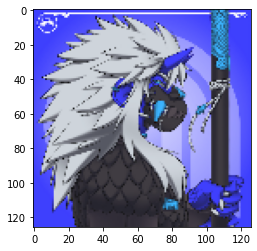

In [ ]:
image = skimage.img_as_ubyte(X[0])
plt.imshow(image)

In [ ]:
Y = df.price_quartile.values

In [ ]:
class NftDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.X = x
        self.Y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        img = skimage.img_as_ubyte(self.X[index])
        if self.transform:
            img = self.transform(img)
        return img, self.Y[index]

In [ ]:
transform_img = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize((224,224))
])

In [ ]:
dataset = NftDataset(X, Y, transform_img)
train_set, test_set = torch.utils.data.random_split(dataset, [round(0.7*len(dataset)), round(0.3*len(dataset))])

train_loader = DataLoader(dataset=train_set, batch_size=128, drop_last=True, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=128, shuffle=True)

In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 3, 224, 224]) torch.Size([128])


#Resnet-18

In [ ]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 4)
_ = model.cuda()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr)
num_epochs = 10

In [ ]:
train_losses = []
val_losses = []

train_metrics = []
val_metrics = []

hist = {"train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []}

Epoch 9/10	 Loss mean: 0.722570	 Accuracy mean: 0.654414
Epoch 9/10	 Val Loss mean: 0.780270	 Test Accuracy mean: 0.636332


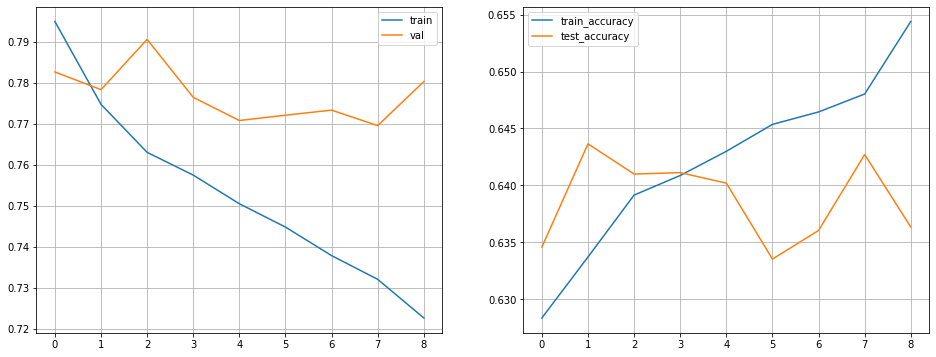

Epoch: 10 	Loss: 0.772780
Epoch: 10 	Loss: 0.670944
Epoch: 10 	Loss: 0.615679
Epoch: 10 	Loss: 0.677308
Epoch: 10 	Loss: 0.694590
Epoch: 10 	Loss: 0.651874
Epoch: 10 	Loss: 0.688034
Epoch: 10 	Loss: 0.669711
Epoch: 10 	Loss: 0.709539
Epoch: 10 	Loss: 0.695396
Epoch: 10 	Loss: 0.679408
Epoch: 10 	Loss: 0.616030
Epoch: 10 	Loss: 0.652560
Epoch: 10 	Loss: 0.703337
Epoch: 10 	Loss: 0.711633
Epoch: 10 	Loss: 0.759352
Epoch: 10 	Loss: 0.687674
Epoch: 10 	Loss: 0.686560
Epoch: 10 	Loss: 0.697616
Epoch: 10 	Loss: 0.776418
Epoch: 10 	Loss: 0.654584
Epoch: 10 	Loss: 0.711500
Epoch: 10 	Loss: 0.727627
Epoch: 10 	Loss: 0.673585
Epoch: 10 	Loss: 0.763844
Epoch: 10 	Loss: 0.691351
Epoch: 10 	Loss: 0.712902
Epoch: 10 	Loss: 0.807092
Epoch: 10 	Loss: 0.704333
Epoch: 10 	Loss: 0.719817
Epoch: 10 	Loss: 0.708836
Epoch: 10 	Loss: 0.697660
Epoch: 10 	Loss: 0.664627
Epoch: 10 	Loss: 0.698910
Epoch: 10 	Loss: 0.667012
Epoch: 10 	Loss: 0.744293
Epoch: 10 	Loss: 0.763486
Epoch: 10 	Loss: 0.731922
Epoch: 10 	L

In [ ]:
for i in range(num_epochs):
    if i > 0:
        print("Epoch %d/%d\t Loss mean: %f\t Accuracy mean: %f"% \
                (i, num_epochs, epoch_loss, epoch_accuracy))
        print("Epoch %d/%d\t Val Loss mean: %f\t Test Accuracy mean: %f"% \
            (i, num_epochs, test_loss, test_accuracy))

        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(hist['train_loss'], label='train')
        plt.plot(hist['test_loss'], label='val')
        plt.legend()
        plt.grid()

        plt.subplot(122)
        plt.plot(hist['train_accuracy'], label='train_accuracy')
        plt.plot(hist['test_accuracy'], label='test_accuracy')
        plt.legend()
        plt.grid()
        plt.show()


    epoch_losses = []
    test_losses = []
    epoch_accuracies = []
    test_accuracies = []

    model.train()
    for k, (X, Y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X.cuda())
        loss = criterion(y_pred, Y.cuda())
        accuracy = (torch.argmax(y_pred.detach().cpu(), 1) == Y.cpu()).sum()/len(Y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accuracies.append(accuracy)
        if k%10 == 0:
            print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))

    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_accuracy = np.mean(np.array(epoch_accuracies))
    hist['train_accuracy'].append(epoch_accuracy)
    hist['train_loss'].append(epoch_loss)

    with torch.no_grad():
        model.eval()
        for k, (X, Y) in enumerate(test_loader):
            y_pred = model(X.cuda())
            loss = criterion(y_pred, Y.cuda())
            accuracy = (torch.argmax(y_pred.detach().cpu(), 1) == Y.cpu()).sum()/len(Y)
            test_losses.append(loss.item())
            test_accuracies.append(accuracy)

    test_loss = np.mean(np.array(test_losses))
    test_accuracy = np.mean(np.array(test_accuracies))
    hist['test_loss'].append(test_loss)
    hist['test_accuracy'].append(test_accuracy)
    
    if i < (num_epochs - 1):
        clear_output()

In [ ]:
print(hist['test_accuracy'])
print(hist['train_accuracy'])

[0.6345747, 0.6436475, 0.6409935, 0.64111626, 0.6401925, 0.6335121, 0.6360325, 0.64270765, 0.63633156, 0.6342864]
[0.6283344, 0.63369846, 0.63914305, 0.64086664, 0.6429929, 0.6453608, 0.6464562, 0.6480348, 0.65441364, 0.65707153]


#Multi Layer Perceptron

In [ ]:
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(3*224*224, 512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,4)
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)
        return x


model = Net()
print(model)

Net(
  (fc1): Linear(in_features=150528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [ ]:
_ = model.cuda()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr)
num_epochs = 30

In [ ]:
train_losses = []
val_losses = []

train_metrics = []
val_metrics = []

hist = {"train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []}

Epoch 29/30	 Loss mean: 0.794149	 Accuracy mean: 0.625209
Epoch 29/30	 Val Loss mean: 0.779010	 Test Accuracy mean: 0.638484


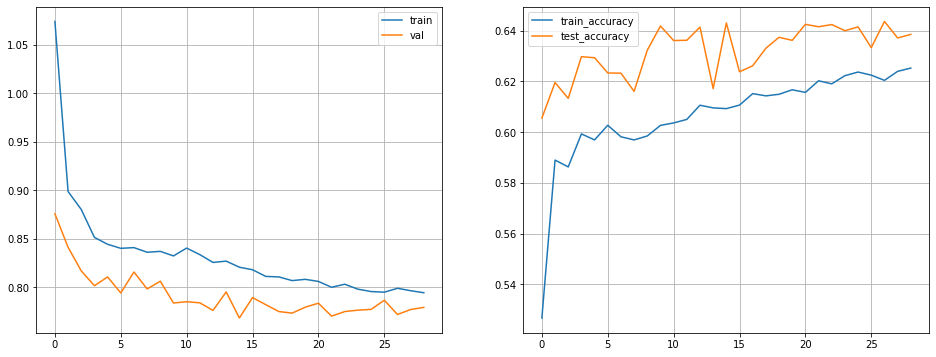

Epoch: 30 	Loss: 0.867526
Epoch: 30 	Loss: 0.764605
Epoch: 30 	Loss: 0.760859
Epoch: 30 	Loss: 0.791736
Epoch: 30 	Loss: 0.805096
Epoch: 30 	Loss: 0.781614
Epoch: 30 	Loss: 0.772705
Epoch: 30 	Loss: 0.783253
Epoch: 30 	Loss: 0.849698
Epoch: 30 	Loss: 0.911674
Epoch: 30 	Loss: 0.894352
Epoch: 30 	Loss: 0.881580
Epoch: 30 	Loss: 0.790545
Epoch: 30 	Loss: 0.783867
Epoch: 30 	Loss: 0.785586
Epoch: 30 	Loss: 0.839016
Epoch: 30 	Loss: 0.826512
Epoch: 30 	Loss: 0.805729
Epoch: 30 	Loss: 0.895718
Epoch: 30 	Loss: 0.718856
Epoch: 30 	Loss: 0.779630
Epoch: 30 	Loss: 0.747635
Epoch: 30 	Loss: 0.906461
Epoch: 30 	Loss: 0.800933
Epoch: 30 	Loss: 0.850420
Epoch: 30 	Loss: 0.788136
Epoch: 30 	Loss: 0.928674
Epoch: 30 	Loss: 0.915427
Epoch: 30 	Loss: 0.832685
Epoch: 30 	Loss: 0.799292
Epoch: 30 	Loss: 0.749142
Epoch: 30 	Loss: 0.835008
Epoch: 30 	Loss: 0.828439
Epoch: 30 	Loss: 0.852091
Epoch: 30 	Loss: 0.760049
Epoch: 30 	Loss: 0.796306
Epoch: 30 	Loss: 0.781756
Epoch: 30 	Loss: 0.749245
Epoch: 30 	L

In [ ]:
for i in range(num_epochs):
    if i > 0:
        print("Epoch %d/%d\t Loss mean: %f\t Accuracy mean: %f"% \
                (i, num_epochs, epoch_loss, epoch_accuracy))
        print("Epoch %d/%d\t Val Loss mean: %f\t Test Accuracy mean: %f"% \
            (i, num_epochs, test_loss, test_accuracy))

        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(hist['train_loss'], label='train')
        plt.plot(hist['test_loss'], label='val')
        plt.legend()
        plt.grid()

        plt.subplot(122)
        plt.plot(hist['train_accuracy'], label='train_accuracy')
        plt.plot(hist['test_accuracy'], label='test_accuracy')
        plt.legend()
        plt.grid()
        plt.show()


    epoch_losses = []
    test_losses = []
    epoch_accuracies = []
    test_accuracies = []

    model.train()
    for k, (X, Y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X.cuda())
        loss = criterion(y_pred, Y.cuda())
        accuracy = (torch.argmax(y_pred.detach().cpu(), 1) == Y.cpu()).sum()/len(Y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accuracies.append(accuracy)
        if k%10 == 0:
            print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))

    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_accuracy = np.mean(np.array(epoch_accuracies))
    hist['train_accuracy'].append(epoch_accuracy)
    hist['train_loss'].append(epoch_loss)

    with torch.no_grad():
        model.eval()
        for k, (X, Y) in enumerate(test_loader):
            y_pred = model(X.cuda())
            loss = criterion(y_pred, Y.cuda())
            accuracy = (torch.argmax(y_pred.detach().cpu(), 1) == Y.cpu()).sum()/len(Y)
            test_losses.append(loss.item())
            test_accuracies.append(accuracy)

    test_loss = np.mean(np.array(test_losses))
    test_accuracy = np.mean(np.array(test_accuracies))
    hist['test_loss'].append(test_loss)
    hist['test_accuracy'].append(test_accuracy)
    
    if i < (num_epochs - 1):
        clear_output()

In [ ]:
print(hist['test_accuracy'])
print(hist['train_accuracy'])

[0.60550344, 0.6195157, 0.6132679, 0.62969387, 0.6292881, 0.62327516, 0.6232004, 0.61604476, 0.63224113, 0.64179987, 0.6360593, 0.6361714, 0.6413513, 0.6171288, 0.642996, 0.6237611, 0.62611073, 0.6330261, 0.63734084, 0.6361447, 0.642446, 0.6414901, 0.64236057, 0.6399415, 0.641426, 0.6332611, 0.64357805, 0.6370739, 0.63848364, 0.6417838]
[0.52672356, 0.58894974, 0.58625966, 0.599259, 0.5969072, 0.60267395, 0.5981314, 0.5968911, 0.5984536, 0.60262567, 0.60359216, 0.6049774, 0.61056703, 0.60951996, 0.60923004, 0.6106153, 0.61514175, 0.6142558, 0.614884, 0.61665595, 0.615625, 0.62019974, 0.6189916, 0.62221324, 0.6236469, 0.6224227, 0.62036085, 0.62392074, 0.6252094, 0.623212]
